# Laboratorium 3 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [4]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans # w tym pakiecie znajdziesz tez inne algorytmy
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud

In [6]:
PATH = './socialmediadata-beeradvocate/data/beer_reviews.csv'
POSITIVE_SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
NEGATIVE_SCORE_THRESHOLD = 2 # recenzje ponizej tego progu wezmiemy jako przyklady negatywne
ACTIVITY_THRESHOLD = 5 # minimalna liczba pozytywnych lub negatywnych recenzji per uzytkownik
MIN_SCORES_COUNT = 5 # minimalna liczba ocen pojedynczego elementu
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [7]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path, positive_score_threshold, negative_score_threshold):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))

        users_favourite_beers = defaultdict(list)
        users_hated_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= positive_score_threshold:
                users_favourite_beers[user_id].append(beer_id)
            elif score <= negative_score_threshold:
                users_hated_beers[user_id].append(beer_id)

    return users_favourite_beers, users_hated_beers

def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers, users_hated_beers = read_and_parse_reviews(PATH, POSITIVE_SCORE_THRESHOLD, NEGATIVE_SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

## Część 2. - osadzenia użytkowników

In [8]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

# needed change for vector_size instead of just size
model = Word2Vec(sentences=users_favourite_beers.values(), vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [9]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

# wektor obliczany dla uzytkownika przez wyliczenie średniej z wektorów jego ulubionych piw
def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    v = np.zeros(vector_size)

    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]

    v /= len(user_favourite_beers)
    return v


# wyliczenie tych wektorów dla kazdego z uzytkowników
def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    mean_users_vectors = {}
    for user in users_favourite_beers:
        current_user_beers = users_favourite_beers[user]
        mean_users_vectors[user] = get_mean_vector_for_user(current_user_beers, model, vector_size)

    return mean_users_vectors

# po wyliczonych wektorach mozemy przypuszczać jak mniej więcej będą wyglądały wektory piw które będą się im podobały
user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

In [10]:
user_vectors

{'johnmichaelsen': array([ 0.50435976,  0.23428789, -0.22021223,  0.3706656 , -0.25725869,
        -0.63099808, -0.57852266,  1.25418863, -0.15076002,  0.74846842,
         0.25838903, -0.4954951 ,  0.0687222 ,  0.53496961,  0.67299057,
         0.60439651,  0.33857141, -1.12843314, -0.6317737 , -0.97245979]),
 'LordAdmNelson': array([ 0.95386624,  0.16521656, -0.64263299,  0.55256383, -0.66981607,
        -0.91116597, -0.84322068,  1.86792752,  0.15050521,  1.28489679,
        -0.36436215, -1.03062242,  0.54292654,  0.80848823,  1.13782943,
         1.18023265,  0.37927071, -1.75611792, -0.98783994, -2.06068479]),
 'augustgarage': array([ 0.76344324,  0.37830938, -0.23088818,  0.52403931, -0.29457133,
        -0.76776519, -0.77369853,  1.47925268, -0.0440352 ,  0.92599007,
         0.48611752, -0.6052181 ,  0.20808607,  0.63982578,  0.82751914,
         0.82189198,  0.32943877, -1.40107207, -0.79225905, -1.35971617]),
 'MadeInOregon': array([ 0.67917512, -0.03395497, -0.68006671,  1.0

## Część 3. - klasteryzacja

In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, porownaj co najmniej 2 rozne


def get_users_segmentation(user_vectors, vector_size, segments_count, isAgglomerative):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = list(user_vectors.keys())
    vectors = list(user_vectors.values())

    # zamieniamy liste wektorow w macierz nakładając je na siebie (tablica 2D)
    users_array = np.stack(vectors, axis=0)

    # clustering sam z siebie zwraca nam numer klastra do którego jest przypisany wektor, clustering[i] to numer klastra do którego nalezy i-ty wektor. Co nam daje ta liczba? Nie określa nam w zaden bezpośredni sposób jak wygląda klaster do którego jest przypisany wektor, ale podobne wektory będą miały takie same numery klastrów (na drodze szukania pradopodobieństwa przez fit_predict najblizsze siebie wektory są przypisywane do tego samego klastra)

    # co turę 2 najblizsze siebie wektory są zamieniane w 1 az osiągniemy zamierzoną liczbę wektorów
    if isAgglomerative:
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(users_array)
    # co turę przypisuj wektory do najblizszych im centroidów po odległości euklidesowej, a następnie wybieraj nowe centroidy jako średnia ze współrzędnych wektorów w kazdym z klastrów. Algorytm trwa do momentu osiągnięcia jakiegoś epsilon małości zmian centroidów
    else:
        clustering = KMeans(n_clusters=segments_count).fit_predict(users_array)

    segmentation = {}
    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    for i, user_id in enumerate(users):
        segmentation[user_id] = clustering[i]

    return segmentation


segmentationA = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, True)

segmentationK = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, False)

/Users/wiktorgut/Desktop/rekomendacyjne/recsyslab3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    segmentation_values = [_ for _ in segmentation.values()]
    return {cluster : segmentation_values.count(cluster) for cluster in segmentation_values}

print(get_segment_sizes(segmentationA))
print(get_segment_sizes(segmentationK))

{0: 13879, 7: 3290, 9: 3242, 4: 2441, 3: 1581, 1: 1730, 5: 1308, 6: 1012, 2: 985, 8: 818}
{1: 6493, 5: 12096, 9: 1530, 2: 1507, 7: 1156, 0: 1164, 3: 2369, 6: 1658, 8: 889, 4: 1424}


In [25]:
# obliczamy metryke jakosci segmentacji
# metryka przyjmuje wartosci [-1, 1] - im wiecej, tym lepiej
users, user_vectors_list = zip(*user_vectors.items())
segments_list1 = [segmentationA[u] for u in users]
segments_list2 = [segmentationK[u] for u in users]

mean_silhouette1 = silhouette_score(user_vectors_list, segments_list1, metric='euclidean')
per_sample_silhouettes1 = silhouette_samples(user_vectors_list, segments_list1, metric='euclidean')

mean_silhouette2 = silhouette_score(user_vectors_list, segments_list2, metric='euclidean')
per_sample_silhouettes2 = silhouette_samples(user_vectors_list, segments_list2, metric='euclidean')

In [27]:
# rysujemy wykres
def plot_histogram(values, mean_value):
    plt.hist(values, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_value, linestyle='dashed', linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height*1.05, 'Mean: {:.3f}'.format(mean_value))
    plt.show()

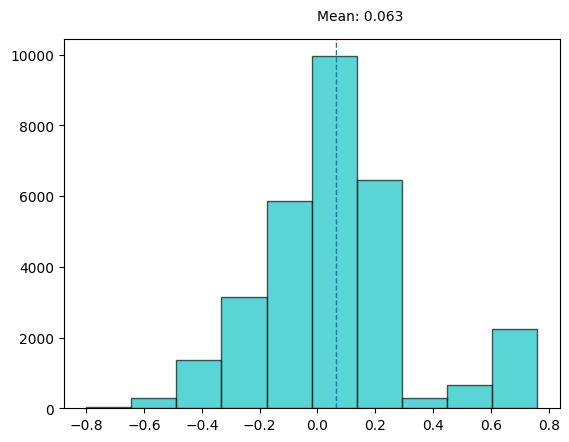

In [28]:
plot_histogram(per_sample_silhouettes1, mean_silhouette1)

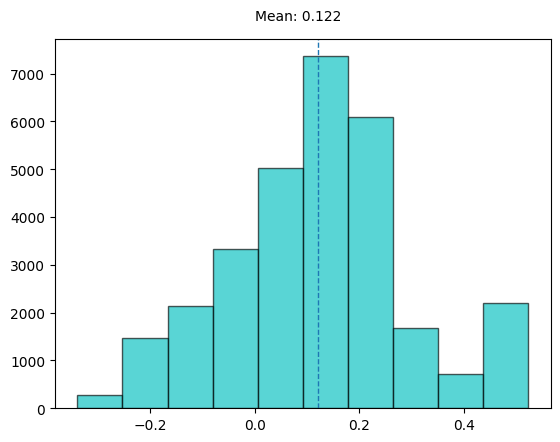

In [29]:
plot_histogram(per_sample_silhouettes2, mean_silhouette2)

## Część 3.5. - negative sampling

Wykonaj kroki obliczania embeddingów uytkowników, klasteryzacji z uyciem najlepszego według Ciebie algorytmu i obliczania sylwetki - ale tym razem embeddingi to średnia waona, gdzie elementy `users_favourite_beers[user_id]` mają wagę `1`, a elementy `users_hated_beers[user_id]` mają wagę `-1`.

Możesz także odsiać tych użytkowników, o których wiemy zbyt mało (czyli którzy mają łącznie mniej niż `ACTIVITY_THRESHOLD` elementów w listach `users_favourite_beers[user_id]` i `users_hated_beers[user_id]`).

Weighted Mean Silhouette Score: 0.016566438790219306


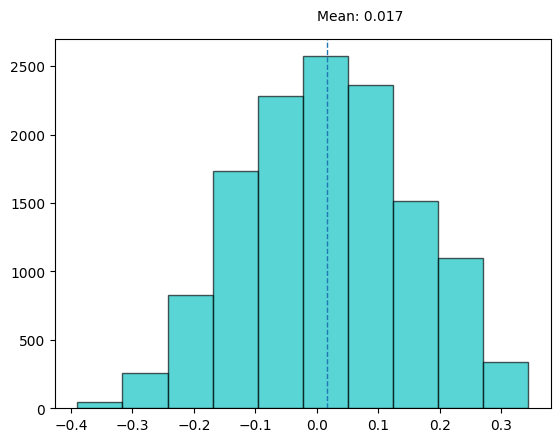

In [30]:
def get_weighted_mean_vector_for_user(user_id, users_favourite_beers, users_hated_beers, model, vector_size):
    v = np.zeros(vector_size)
    weight_sum = 0
    for beer_id in users_favourite_beers.get(user_id, []):
        try:
            v += model.wv[beer_id]
            weight_sum += 1
        except KeyError:
            pass
    for beer_id in users_hated_beers.get(user_id, []):
        try:
            v -= model.wv[beer_id]
            weight_sum += 1
        except KeyError:
            pass

    v /= weight_sum
    return v

def get_weighted_mean_user_vectors(users_favourite_beers, users_hated_beers, model, vector_size, activity_threshold):
    weighted_mean_users_vectors = {}
    for user_id in set(users_favourite_beers.keys()).union(users_hated_beers.keys()):
        if len(users_favourite_beers.get(user_id, [])) + len(users_hated_beers.get(user_id, [])) >= activity_threshold:
            weighted_mean_users_vectors[user_id] = get_weighted_mean_vector_for_user(user_id, users_favourite_beers, users_hated_beers, model, vector_size)
    return weighted_mean_users_vectors

weighted_user_vectors = get_weighted_mean_user_vectors(users_favourite_beers, users_hated_beers, model, VECTOR_SIZE, ACTIVITY_THRESHOLD)
weighted_segmentation = get_users_segmentation(weighted_user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, False)

weighted_users, weighted_user_vectors_list = zip(*weighted_user_vectors.items())
weighted_segments_list = [weighted_segmentation[u] for u in weighted_users]

weighted_mean_silhouette = silhouette_score(weighted_user_vectors_list, weighted_segments_list, metric='euclidean')
weighted_per_sample_silhouettes = silhouette_samples(weighted_user_vectors_list, weighted_segments_list, metric='euclidean')

print(f"Weighted Mean Silhouette Score: {weighted_mean_silhouette}")

# mowi nam ze srednio wiekszosc piw nie spasuje userowi
plot_histogram(weighted_per_sample_silhouettes, weighted_mean_silhouette)

## Część 4. - opisy segmentów

In [31]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, segments_count):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]

    for user, beers in users_favourite_beers.items():
        segment_beer_styles = []
        for beer in beers:
            beer_styles_per_segment[segmentation[user]][beer_styles[beer]] += 1

    return beer_styles_per_segment

def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)

    for segment in beer_styles_per_segment.keys():
        for style in beer_styles_per_segment[segment]:
            total_popularity[style] += beer_styles_per_segment[segment][style]

    return total_popularity

per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation2, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [33]:
from copy import copy
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    res = {}
    for segment in per_segment_styles_popularity.keys():
        # biore N najlepszych styli w kazdym segmencie
        frequency_of_styles_in_segment = per_segment_styles_popularity[segment].items()
        frequency_per_style_dict = sorted(frequency_of_styles_in_segment, key=lambda x:x[1], reverse=True)
        res[segment] = dict(frequency_per_style_dict[:N])
    return res

def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    res = {}
    distincive_popularity = copy(per_segment_styles_popularity)

    # Obliczam popularnosc w segmecie przez łączoną popularnośc w wszystkich
    for segment in per_segment_styles_popularity.keys():
        for style in per_segment_styles_popularity[segment].keys():
            distincive_popularity[segment][style] /= total_styles_popularity[style]

    # biore N najbardziej populranych w kazdym segmencie po podzieleniu
    for segment in distincive_popularity.keys():
        uniqueness_of_styles_per_segment = distincive_popularity[segment].items()
        uniqueness_per_style_dict = sorted(distincive_popularity[segment].items(), key=lambda x:x[1], reverse=True)
        res[segment] = dict(uniqueness_per_style_dict[:N])

    return res

top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

## Część 5. - wizualizacja

In [34]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

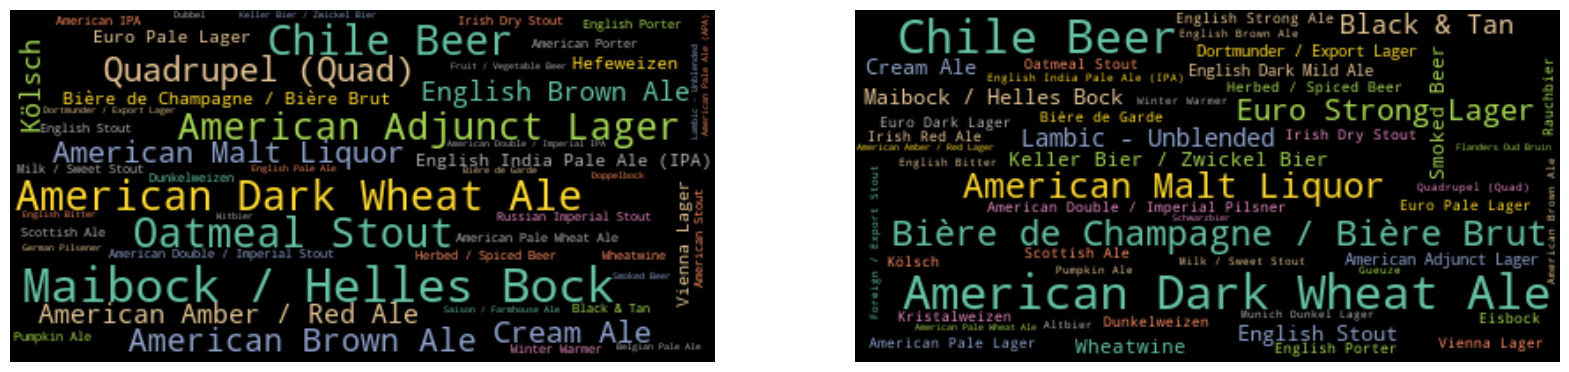

In [35]:
visualise_styles(most_popular, most_distinctive, 1)

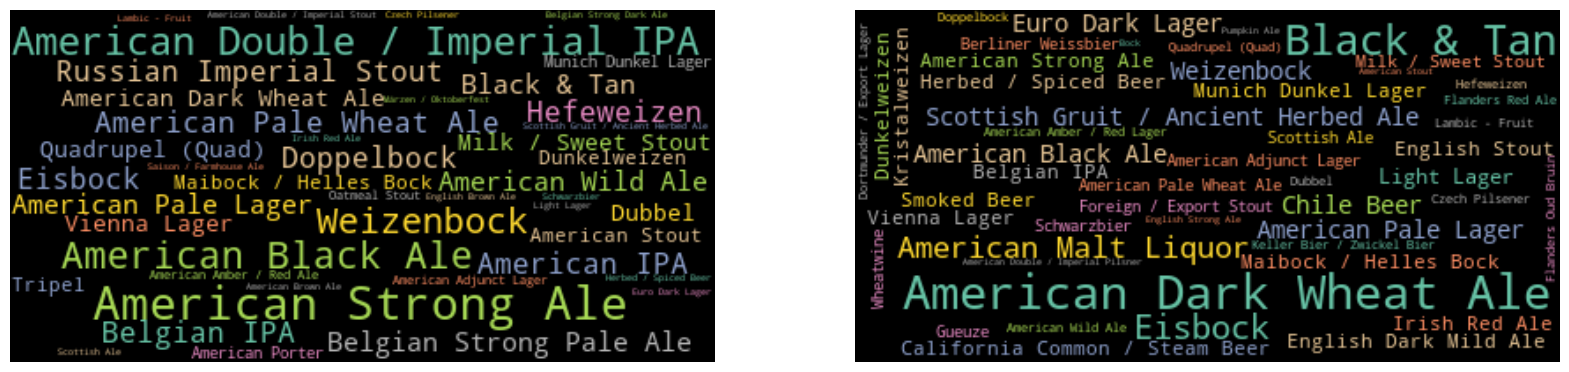

In [36]:
visualise_styles(most_popular, most_distinctive, 3)